In [27]:
import os
from collections import Counter
import nltk
import gensim  #for topic modelling
from bs4 import BeautifulSoup #for extracting text 
import nltk # for text preprocessing
import re 
import pandas as pd
import numpy as np
import sys
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import string
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
matplotlib.rcParams['figure.figsize'] = (20,10)

### read data

In [2]:
path = './inaugural_speeches/'
files = [path + fname for fname in os.listdir(path)]

In [3]:
data = []
for fname in files:
    with open(fname, 'r') as f:
        lines = ' '.join(f.readlines())
        data.append(lines)

In [49]:
#stoplist = set([u'state', u'country', u'nation', u'people', u'constitution',u'duty', u'government', u'citizen', u'law', u'right', u'union',u'power', u'year', u'world', u'interest', u'purpose', u'justice',u'principle', u'it', u'time', u'question', u'executive', u'war',u'peace', u'life', u'institution', u'condition', u'effort', u'land',u'faith', u'place', u'office', u'today', u'thing', u'opinion',u'home', u'action', u'god', u'cause', u'century', u'strength',u'authority', u'danger', u'revenue', u'prosperity', u'subject',u'republic', u'generation', u'business', u'character'])
stoplist = set([u'state', u'country', u'nation', u'people', u'constitution',u'duty', u'government', u'citizen'])

###  remove stopwords, punctuation, pos tag

In [50]:
stop = set(stopwords.words('english'))
stop.update(stoplist)
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    punc_free = ''.join(ch for ch in doc if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    doc_filter = " ".join([word for word, pos in nltk.pos_tag(normalized.lower().split()) if 'NN' in pos ])
    stop_free = " ".join([i for i in doc_filter.split() if i not in stop])
    
    return stop_free

In [51]:
doc_clean = [clean(doc).split() for doc in data]

### pos distribution

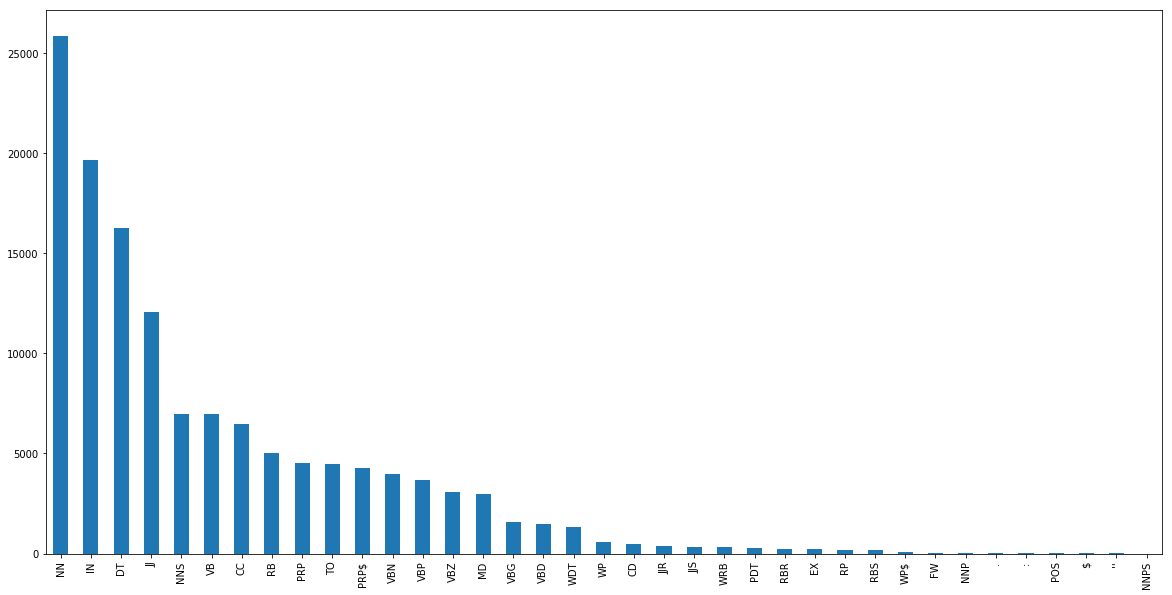

In [53]:
pos = [pos for doc in data for word, pos in nltk.pos_tag(doc.lower().split())]
pos = pd.Series(pos)
pos.value_counts().head(50).plot.bar()

### word distribution

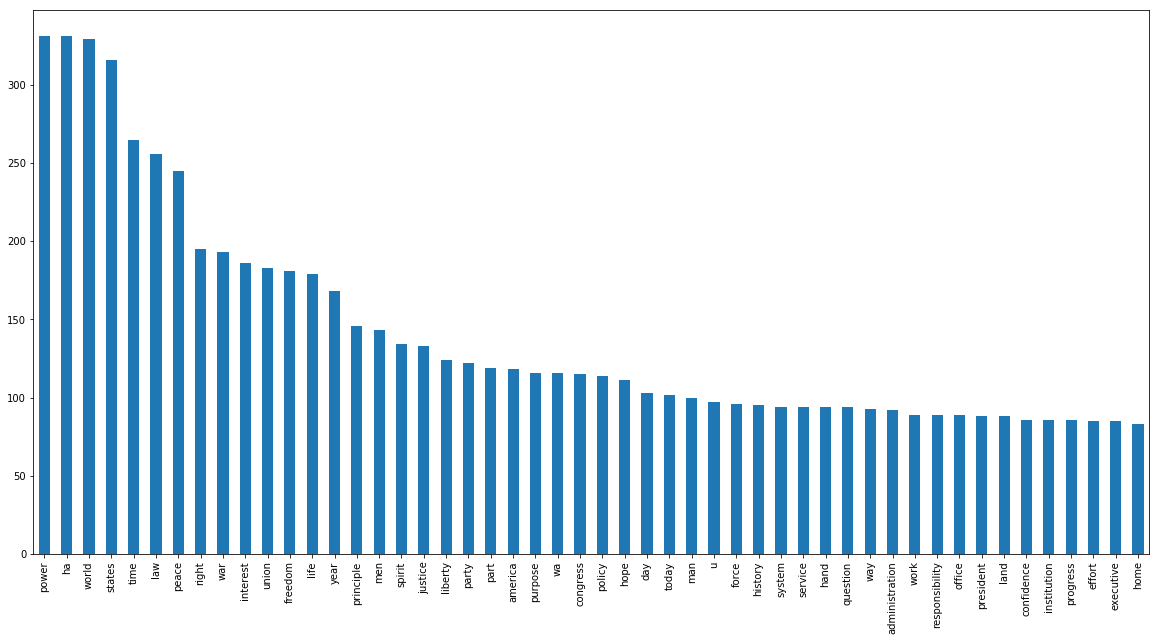

In [54]:
all_tokens = [x for y in doc_clean for x in y]
all_tokens = pd.Series(all_tokens)
all_tokens.value_counts().head(50).plot.bar()

In [55]:
all_tokens.value_counts().head(50).index.values

array(['power', 'ha', 'world', 'states', 'time', 'law', 'peace', 'right',
       'war', 'interest', 'union', 'freedom', 'life', 'year', 'principle',
       'men', 'spirit', 'justice', 'liberty', 'party', 'part', 'america',
       'purpose', 'wa', 'congress', 'policy', 'hope', 'day', 'today',
       'man', 'u', 'force', 'history', 'system', 'service', 'hand',
       'question', 'way', 'administration', 'work', 'responsibility',
       'office', 'president', 'land', 'confidence', 'institution',
       'progress', 'effort', 'executive', 'home'], dtype=object)

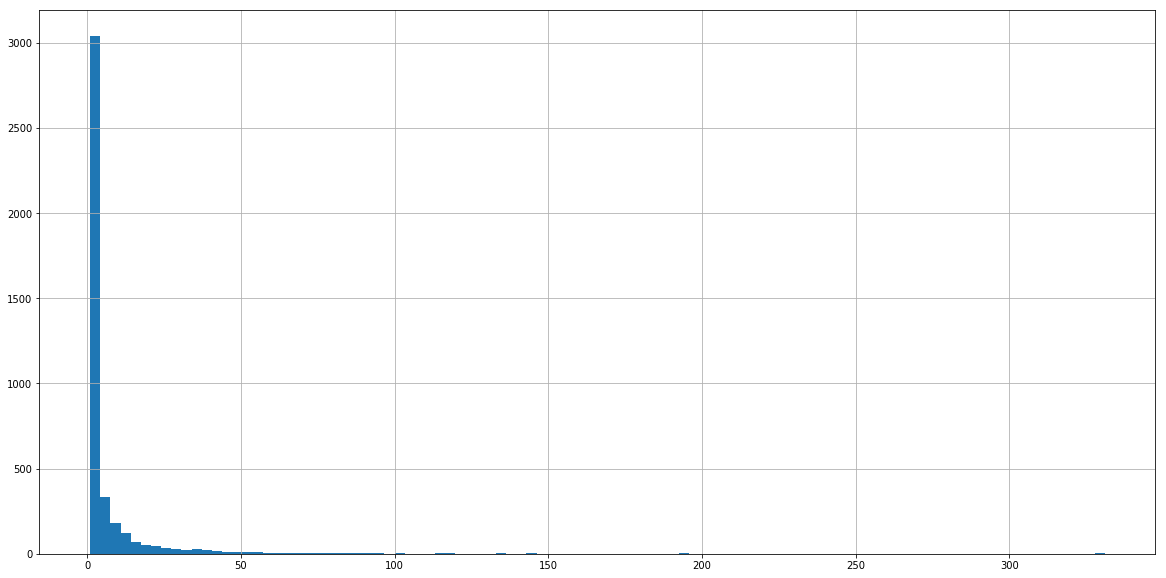

In [56]:
all_tokens.value_counts().hist(bins=100)

### plot theme of some transcripts

(-0.5, 399.5, 199.5, -0.5)

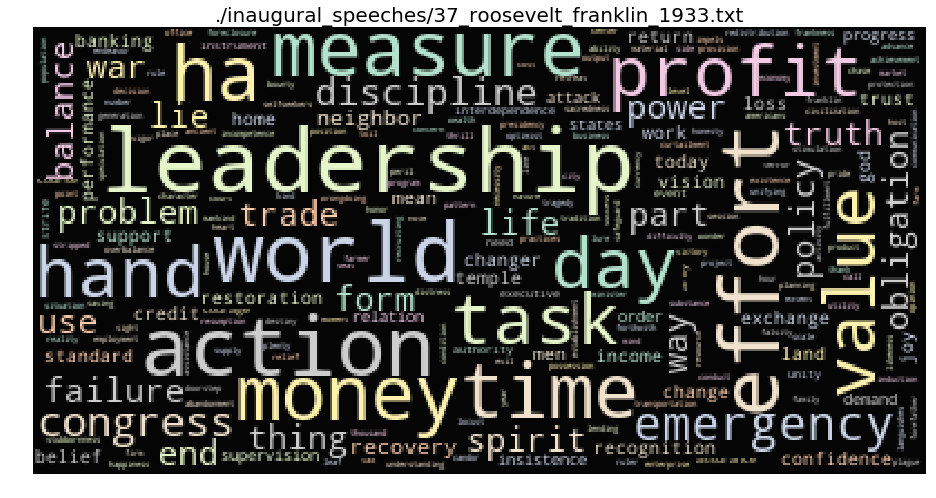

In [36]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(doc_clean[0])
plt.title(files[0], fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

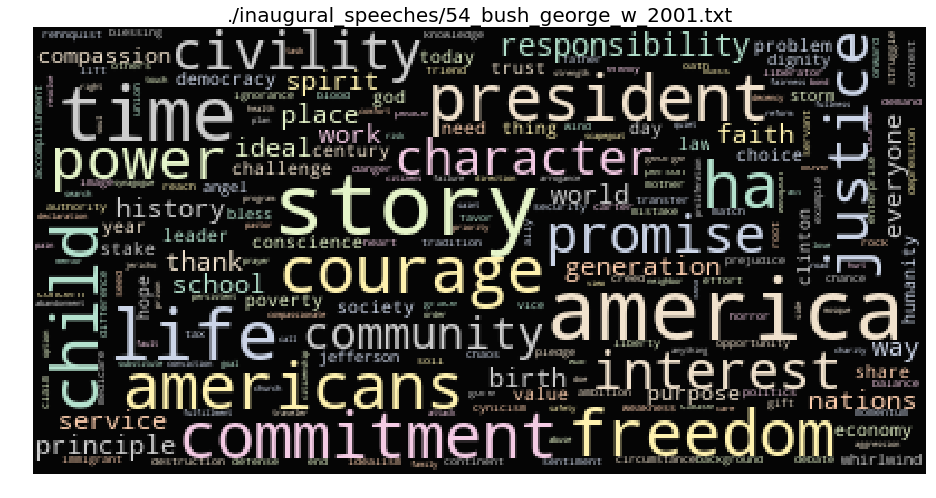

In [37]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(doc_clean[1])
plt.title(files[1], fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

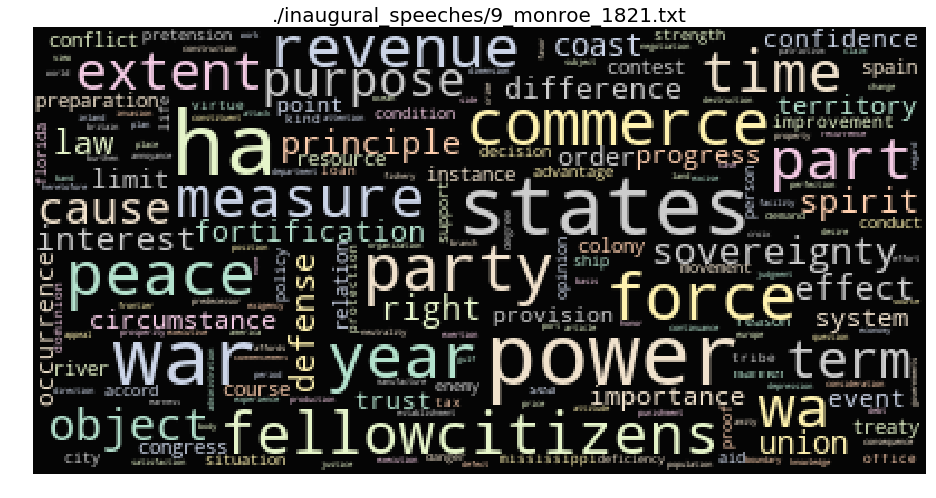

In [38]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(doc_clean[56])
plt.title(files[56], fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

In [57]:
#stemmer = nltk.stem.PorterStemmer()
#questions_stemmed = [[stemmer.stem(token) for token in tokens] for tokens in all_tokens]
questions_stemmed = doc_clean

In [58]:
word_counts = pd.Series(np.concatenate(questions_stemmed)).value_counts()
singular_words = set(word_counts[pd.Series(np.concatenate(questions_stemmed)).value_counts() <= 3].index)

In [59]:
len(singular_words)

2844

In [60]:
questions_stemmed = [[word for word in title if word not in singular_words] for title in questions_stemmed]

In [61]:
non_empty_indices = [i for i in range(len(questions_stemmed)) if len(questions_stemmed[i]) > 0]
questions_stemmed = np.asarray(questions_stemmed)[non_empty_indices]

In [62]:
dictionary = gensim.corpora.Dictionary(questions_stemmed)

In [63]:
corpus = [dictionary.doc2bow(text) for text in questions_stemmed]


In [122]:
model =  gensim.models.ldamodel.LdaModel
ldamodel = model(corpus, num_topics=20, id2word = dictionary, passes=100)

In [131]:
ldamodel.print_topics(num_topics=3, num_words=20)

[(8,
  '0.019*"law" + 0.013*"states" + 0.013*"men" + 0.012*"party" + 0.011*"interest" + 0.011*"ha" + 0.011*"power" + 0.009*"justice" + 0.008*"year" + 0.008*"purpose" + 0.008*"congress" + 0.008*"life" + 0.008*"office" + 0.007*"action" + 0.007*"election" + 0.007*"policy" + 0.007*"right" + 0.007*"thing" + 0.007*"condition" + 0.007*"service"'),
 (16,
  '0.048*"union" + 0.026*"peace" + 0.022*"year" + 0.020*"ha" + 0.019*"generation" + 0.018*"covenant" + 0.016*"way" + 0.014*"justice" + 0.014*"men" + 0.013*"land" + 0.013*"freedom" + 0.012*"war" + 0.011*"today" + 0.010*"earth" + 0.009*"stranger" + 0.009*"purpose" + 0.009*"hope" + 0.008*"heart" + 0.008*"democracy" + 0.008*"dominion"'),
 (0,
  '0.001*"world" + 0.001*"war" + 0.001*"time" + 0.001*"ha" + 0.001*"power" + 0.001*"states" + 0.001*"union" + 0.001*"men" + 0.001*"law" + 0.001*"service" + 0.001*"peace" + 0.001*"right" + 0.001*"year" + 0.001*"interest" + 0.001*"wa" + 0.001*"effort" + 0.001*"congress" + 0.001*"spirit" + 0.001*"change" + 0.001

In [128]:
ldamodel.show_topics()

[(1,
  '0.001*"power" + 0.001*"states" + 0.001*"ha" + 0.001*"law" + 0.001*"right" + 0.001*"peace" + 0.001*"world" + 0.001*"time" + 0.001*"principle" + 0.001*"policy"'),
 (13,
  '0.001*"ha" + 0.001*"law" + 0.001*"states" + 0.001*"power" + 0.001*"union" + 0.001*"principle" + 0.001*"party" + 0.001*"interest" + 0.001*"peace" + 0.001*"time"'),
 (2,
  '0.049*"peace" + 0.044*"responsibility" + 0.043*"world" + 0.025*"home" + 0.024*"year" + 0.024*"america" + 0.022*"let" + 0.019*"policy" + 0.019*"role" + 0.018*"ha"'),
 (17,
  '0.001*"power" + 0.001*"states" + 0.001*"ha" + 0.001*"world" + 0.001*"law" + 0.001*"union" + 0.001*"time" + 0.001*"men" + 0.001*"peace" + 0.001*"freedom"'),
 (7,
  '0.023*"oath" + 0.012*"voice" + 0.012*"punishment" + 0.012*"solemn" + 0.012*"confidence" + 0.012*"presence" + 0.012*"upon" + 0.012*"office" + 0.012*"honor" + 0.012*"occasion"'),
 (6,
  '0.023*"power" + 0.022*"states" + 0.016*"ha" + 0.014*"union" + 0.012*"principle" + 0.011*"interest" + 0.010*"right" + 0.009*"fell

In [76]:
doc_clean = [clean(doc) for doc in data]
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
wordvector_fit = wordvector.fit_transform(doc_clean)
feature = wordvector.get_feature_names()

In [117]:
N = 6
clf = KMeans(n_clusters=N,
            max_iter=100,
            init='k-means++',
            n_init=1)
labels = clf.fit_predict(wordvector_fit)

In [118]:
wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

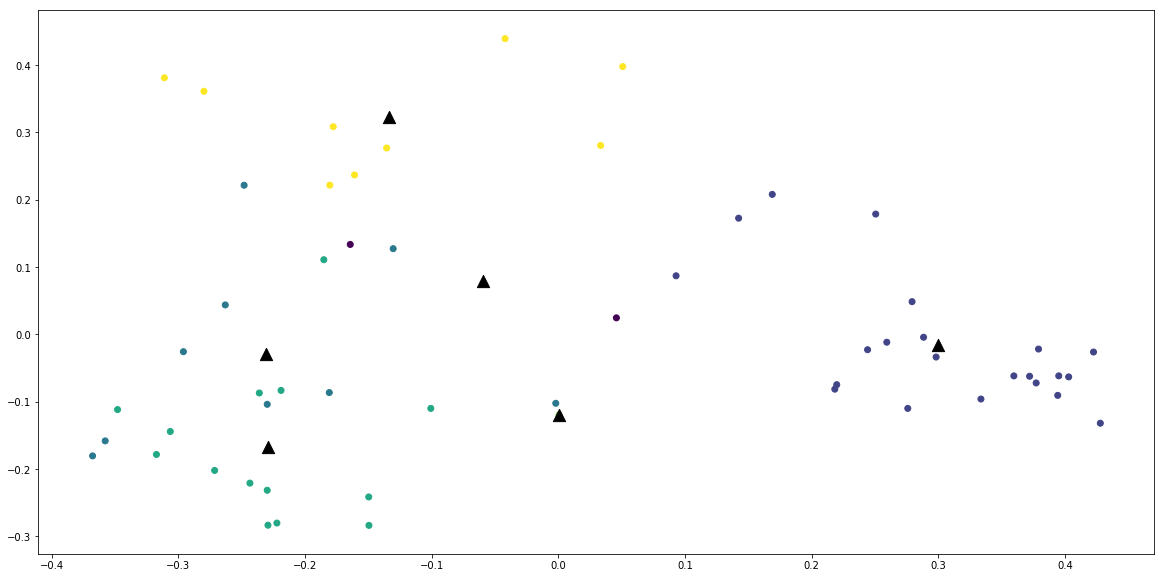

In [119]:
#label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0"]
#color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=labels)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()